In [3]:
from google.cloud import bigquery
import google.datalab.bigquery as bq
import matplotlib.pyplot as plt
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from IPython.display import clear_output
from scipy import stats
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%load_ext google.cloud.bigquery

In [4]:
%%bq query -n all_data
SELECT * FROM `csc672-capstone.csc672_project.csc672_table`

In [5]:
#10% Sample of the data
sampling = bq.Sampling.random(percent=10)
job = all_data.execute(sampling=sampling)
job.result()

f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
1.9655353894369871,3.2636406358678913,8.439873372505721,3.2076128273469378,3.5067331320159765,10.161280650613378,-1.0447546242560657,-0.16668935847080157,-15.726883930107046,20.09805490886592,-1.8608999471198722,4.157648047401516,1,0,0,0
1.8703103835376609,3.417860521516889,8.305920253087507,2.730237875123664,3.5067331320159765,10.84058628403527,-3.04533391978378,-0.3098749289082259,-9.084082125930632,15.85906288423888,-1.8608999471198722,4.157648047401516,1,0,1,1
1.9132159423710307,3.2636406358678913,8.34352469378153,2.839861338656518,3.5067331320159765,10.161280650613378,-2.0865392982771027,-0.16668935847080157,-14.489324772630656,16.987718837084152,-1.8608999471198722,4.157648047401516,1,0,0,0
0.976481807743312,3.2636406358678913,8.94663229001906,3.581365348430812,3.5067331320159765,10.161280650613378,-2.4002937958747435,-0.16668935847080157,-11.976511201299246,9.850093453658753,-1.8608999471198722,4.157648047401516,0,0,1,0
-1.6080382096135564,3.2636406358678913,9.289003803144388,3.735870942448979,3.5067331320159765,12.260126950389722,-2.0865392982771027,-4.348890065850933,-11.067974381522065,9.850093453658753,-1.8608999471198722,4.157648047401516,0,0,0,0
1.9221483877296208,3.2636406358678913,8.359398996518262,3.581365348430812,3.5067331320159765,10.161280650613378,-1.1804571490878937,-0.16668935847080157,-13.960403456890681,17.70915633789763,-1.8608999471198722,4.157648047401516,1,0,0,1
0.4076952837205732,3.2636406358678913,8.628598025375561,2.968076669026976,3.5067331320159765,10.161280650613378,-1.6245277688658053,-0.16668935847080157,-15.089779799640763,17.412281698329412,-1.8608999471198722,4.157648047401516,1,0,0,0
1.6998729675108517,3.2636406358678913,8.357598526080384,2.172527173814257,3.5067331320159765,10.161280650613378,-3.427959945392552,-0.16668935847080157,-12.324453740503543,18.03909690049357,-1.8608999471198722,4.157648047401516,1,0,1,0
-0.2986892827093284,3.2636406358678913,9.152934012939284,3.735870942448979,3.5067331320159765,11.322561301226756,-1.4192082195759292,-4.521285189739835,-11.976511201299246,9.850093453658753,-1.8608999471198722,4.157648047401516,1,0,0,0
-0.351430946484403,3.2636406358678913,8.395485381575146,3.735870942448979,3.5067331320159765,10.161280650613378,-2.7053297739571622,-0.16668935847080157,-9.432024665134927,16.591567936434895,-1.8608999471198722,4.157648047401516,1,0,0,0


In [6]:
all_df = all_data.execute(sampling=sampling, output_options=bq.QueryOutput.dataframe()).result()
len(all_df)

2532340

# Average Treatment Effect (ATE)

In [7]:
#Splitting the data frame into the base (control group) and variant (treatment group)
base = all_df[all_df.treatment == 0]
variant = all_df[all_df.treatment == 1]

In [8]:
#Creating delta variable, the difference between the average conversion rate between variant and base
delta = variant.conversion.mean() - base.conversion.mean()
print(delta)

0.0006950073996512764


In [9]:
#creating the Standard Error for the difference between the two
delta_err = 1.96 * np.sqrt(variant.conversion.var() / variant.shape[0] + base.conversion.var() / base.shape[0])
print(delta_err)

0.00014454464937112963


In [10]:
#Prints the number of conversions for the control group, the size of the control group and the conversion rate
print("Control: %s, N = %s, Rate: %s" % ( all_df[all_df.treatment == 0]['conversion'].sum() 
                                        , all_df[all_df.treatment == 0].shape[0]
                                        , all_df[all_df.treatment == 0]['conversion'].sum() / float(all_df[all_df.treatment == 0].shape[0]
     )))

Control: 660, N = 390209, Rate: 0.001691401274701506


In [11]:
print("The percentage of control users within the 10% sample is ", round(389568/2531283, 2),'%')

The percentage of control users within the 10% sample is  0.15 %


In [12]:
#Prints the number of conversions for the treatment group, the size of the treatment group and the conversion rate
print("Test: %s, N = %s, Rate: %s" % (all_df[all_df.treatment == 1]['conversion'].sum()
                                    , all_df[all_df.treatment == 1].shape[0]
                                    , all_df[all_df.treatment == 1]['conversion'].sum() / float(all_df[all_df.treatment == 1].shape[0]
     )))

Test: 5112, N = 2142131, Rate: 0.0023864086743527824


In [13]:
print("The percentage of treatment users within the 10% sample is ", round(2141715/2531283, 2),'%')

The percentage of treatment users within the 10% sample is  0.85 %


In [14]:
print("estimated_effect %s, standard_error: %s" % (delta, delta_err))

estimated_effect 0.0006950073996512764, standard_error: 0.00014454464937112963


In [15]:
#Creates the lift variable - the % difference between the conversion rates of the treatment and control group
lift = (variant.conversion.mean() - base.conversion.mean()) / base.conversion.mean()
print("Lift: %s" % lift)
#Runs a T Test between the exposed and control group, prints the test statistic and p value
t = stats.ttest_ind(all_df[all_df.treatment == 1]['conversion'], all_df[all_df.treatment == 0]['conversion'])
print("Test Statistic: %s, P-Value: %s" % (t[0], t[1]))

Lift: 0.4109062763795832
Test Statistic: 8.373350559298599, P-Value: 5.603064597342873e-17


# ATE: Results
Above, we can see there is a difference in conversion rate between the control and test, resulting in a 32% lift in conversion. Albeit, the conversion rate is very low at .18% and .24% for control and test, respectively.

Now that we have established that there is a difference is test and control conversion rates, we can proceed with Uplift Modeling.

Moving forward, we will build a model to predict conversion on the treatment dataset. We will use under sampling to balance the outcome class during training.

In [16]:
normalized_df=(all_df-all_df.min())/(all_df.max()-all_df.min())
normalized_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,0.751817,0.128434,0.240332,0.632190,0.074267,0.319622,0.445508,0.672822,0.421300,0.545341,0.553136,0.084991,1.0,0.0,0.0,1.0
1,0.699040,0.128434,0.550237,0.798120,0.000000,0.211259,0.610091,0.449747,0.358822,0.054228,1.000000,0.000000,1.0,0.0,0.0,0.0
2,0.445374,0.000000,0.888842,0.940954,0.000000,0.000000,0.695259,1.000000,0.710898,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0
3,0.914742,0.128434,0.093151,0.716626,0.000000,0.346778,0.466591,0.745898,0.632938,0.286218,1.000000,0.000000,1.0,0.0,1.0,1.0
4,0.955491,0.000000,0.740920,0.579088,0.000000,0.211259,0.456492,0.259076,0.465084,0.000000,1.000000,0.000000,1.0,0.0,0.0,1.0


In [17]:
# subset dataset and train model for treatment
X_train, X_test, y_train, y_test = train_test_split(normalized_df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']][normalized_df.treatment == 1], normalized_df['conversion'][normalized_df.treatment == 1], test_size=0.1, random_state=35)

In [18]:
treatment_model = RandomForestClassifier(n_estimators=50)
treatment_model_fit = treatment_model.fit(X_train, y_train)

y_pred = treatment_model.predict(X_test)
preds = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

Accuracy: 99.75%
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00    213673
        1.0       0.50      0.05      0.09       541

avg / total       1.00      1.00      1.00    214214

[[213647     26]
 [   515     26]]


In [19]:
treatment_results               = pd.DataFrame(y_test)
treatment_results['treatment']  = 1
treatment_results['prob']       = treatment_model.predict_proba(X_test)[:,1]
treatment_results['prediction'] = treatment_model.predict(X_test)
treatment_results.head()

,conversion,treatment,prob,prediction
1235131,0.0,1,0.000000,0.0
1802826,0.0,1,0.000000,0.0
984613,0.0,1,0.000000,0.0
684940,0.0,1,0.000000,0.0
1052937,0.0,1,0.001315,0.0


Text(0.5,1,'Gain Chart')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


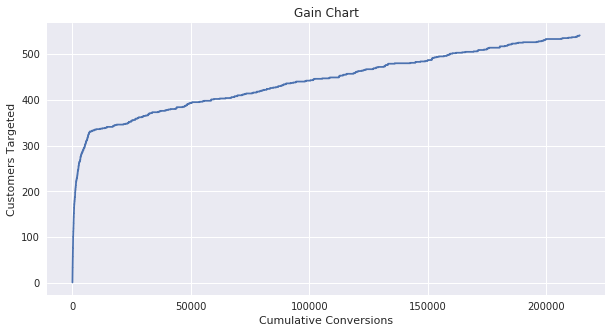

In [20]:
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = [10, 5]
treatment_results = treatment_results.sort_values(by=['prob'], ascending=False)
number_purchases = treatment_results['conversion'].cumsum()
number_targeted  = treatment_results['treatment'].cumsum()
plt.plot(number_targeted, number_purchases)
plt.xlabel("Cumulative Conversions")
plt.ylabel("Customers Targeted")
plt.title("Gain Chart")

In [21]:
treatment_results.head(15)

,conversion,treatment,prob,prediction
441411,1.0,1,0.88,1.0
228035,1.0,1,0.84,1.0
1297,0.0,1,0.82,1.0
148819,1.0,1,0.82,1.0
9386,0.0,1,0.82,1.0
453511,1.0,1,0.82,1.0
371556,0.0,1,0.76,1.0
442400,0.0,1,0.74,1.0
252781,1.0,1,0.74,1.0
172183,0.0,1,0.74,1.0


Text(0.5,1,'Gains Chart')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


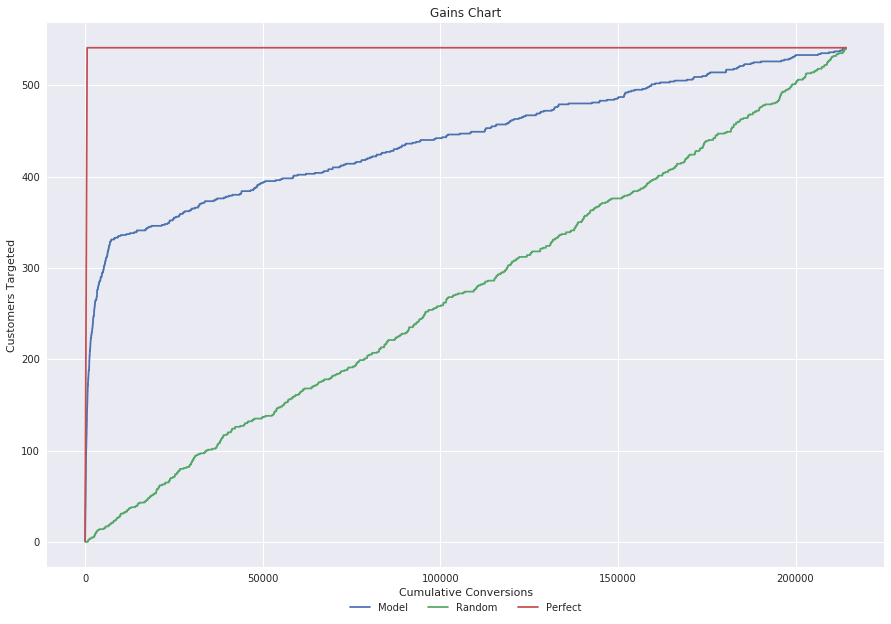

In [22]:
plt.rcParams['figure.figsize'] = [15, 10]
# add random targeting
treatment_results['random_prob'] = [ np.random.random()  for k in treatment_results.index]
treatment_results = treatment_results.sort_values(by=['random_prob'], ascending=False)
rand_number_purchases = treatment_results['conversion'].cumsum()
rand_number_targeted  = treatment_results['treatment'].cumsum()

# add perfect targeting 
treatment_results = treatment_results.sort_values(by=['conversion'], ascending=False)
optimum_number_purchases = treatment_results['conversion'].cumsum()
optimum_number_targeted  = treatment_results['treatment'].cumsum()

plt.plot( number_targeted          ,  number_purchases, label='Model')
plt.plot( rand_number_targeted     ,  rand_number_purchases, label='Random')
plt.plot( optimum_number_targeted  ,  optimum_number_purchases, label='Perfect')
plt.xlabel("Cumulative Conversions")
plt.ylabel("Customers Targeted")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.title("Gains Chart")

# Gini Coefficient

From the gains chart, one defines the Gini coefficient as the ratio between two areas:

- The area above the diagonal line (random model) and the cumulative gains line;
- The area between the diagonal and the optimum

Below, we will calculate this.

In [23]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [24]:
print(type(y_test))
print(type(preds))

<class 'pandas.core.series.Series'>
<class 'list'>


In [25]:
preds_np = np.array(preds)

In [26]:
gini = Gini(y_test, preds_np)
print("The Gini Coefficient for this classifier is: ", gini)

The Gini Coefficient for this classifier is:  0.012878827324835888


# From Gini to Qini

Now, using the Gini metric/curve for evaluating an Uplift Modeling doesn't make as much sense as we don't know the true counterfactual outcome. That is, we want to see how well our Uplift model is at predicting uplift, but since we don't know the outcome of the counterfactual (i.e. what somebody would have done given other action), we can't plot this at an individual level.

However, we can compare segments of the population. For example, we can sort the dataframe by uplift score (descending). Then for each decile in test and control we calculate the number of positive outcomes. We then subtract the number of positive outcomes in treatment minus the number in control. This give us incremental sales or uplift per decile.

Now let's step back, for a second, and think about why this makes sense. If we sort by uplift and segment test and control populations by decile, the first decile in the test group should have a large number of converters. These are people how we predicted would convert when shown an ad, and since they are in the treatment group they were shown and ad. Furthermore, we would expect the control to have a low number of conversions. We also predicted they'd convert if shown and ad, however they were not shown and ad, so their likelihood of converting is, most likely, very small. Ideally we will see the highest uplift in the first decile, then it should decrease and level off until the last deciles where we could/should see negative uplift. If we see negative uplift (downlift) in segments we are observing what is known as sleeping dogs (customers who will buy without seeing and ad, but will not buy if they do see an ad).

Below, we will build a model for the control group. We will then subtract the output probabilities of the test model and control model to come up with predicted uplift (two-model approach), after which we will build an Uplift plot.

In [27]:
# build control model # build  
Xc_train, Xc_test, yc_train, yc_test = train_test_split(normalized_df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']][normalized_df.treatment == 0], normalized_df['conversion'][normalized_df.treatment == 0], test_size=0.1, random_state=35)
spw=(yc_train.shape[0] - yc_train.sum()) / yc_train.sum()

control_model = RandomForestClassifier(n_estimators=50)
control_model_fit = control_model.fit(Xc_train, yc_train)

In [28]:
# build test dataframe, combining the test data frames from control and exposed groups
c = pd.concat([Xc_test, yc_test], axis=1)
c['treatment'] = 0
t = pd.concat([X_test, y_test], axis=1)
t['treatment'] = 1
test_df = pd.concat([c, t])

In [29]:
#Building Results dataframe
results                         = pd.DataFrame(test_df['conversion'])
results['treatment']            = test_df['treatment']
results['treatment_prob']       = treatment_model.predict_proba(test_df[test_df.columns[:-2]])[:,1]
results['control_prob']         = control_model.predict_proba(test_df[test_df.columns[:-2]])[:,1]
results['treatment_pred']       = treatment_model.predict(test_df[test_df.columns[:-2]]) 
results['control_pred']         = control_model.predict(test_df[test_df.columns[:-2]])
results.sort_values(by=['treatment_prob'], ascending=False)
results.head(5)

,conversion,treatment,treatment_prob,control_prob,treatment_pred,control_pred
1760652,0.0,0,0.000000,0.000000,0.0,0.0
1145522,0.0,0,0.001315,0.001594,0.0,0.0
2465431,0.0,0,0.000000,0.000000,0.0,0.0
1242603,0.0,0,0.000000,0.000000,0.0,0.0
1863731,0.0,0,0.000000,0.000000,0.0,0.0


In [30]:
results['uplift'] = results['treatment_prob'] - results['control_prob']
results           = results.sort_values(by=['uplift'], ascending=False)
results['random'] = [ np.random.random()  for k in results.index]
results.head(25)

,conversion,treatment,treatment_prob,control_prob,treatment_pred,control_pred,uplift,random
1111284,0.0,1,0.72,0.00,1.0,0.0,0.72,0.021247
1820622,0.0,1,0.70,0.00,1.0,0.0,0.70,0.013428
1943772,0.0,1,0.68,0.00,1.0,0.0,0.68,0.168928
2479786,0.0,1,0.66,0.00,1.0,0.0,0.66,0.108788
1745914,0.0,1,0.64,0.00,1.0,0.0,0.64,0.212970
1821072,0.0,0,0.64,0.00,1.0,0.0,0.64,0.001209
2047912,0.0,1,0.62,0.00,1.0,0.0,0.62,0.201879
2062485,0.0,1,0.60,0.00,1.0,0.0,0.60,0.659253
1373534,0.0,0,0.56,0.00,1.0,0.0,0.56,0.413816
2518455,0.0,1,0.56,0.00,1.0,0.0,0.56,0.613018


In [31]:
#Segmenting the test and control populations into deciles
control_total   = results[results.treatment == 0].shape[0]
treatment_total = results[results.treatment == 1].shape[0]

uplift_ttl = pd.DataFrame({'segment'      : np.arange(0,1.1, .1)                 ,
                           'control_pop'  : np.arange(0,1.1, .1)*control_total   ,
                           'test_pop'     : np.arange(0,1.1, .1)*treatment_total 
                      })
uplift_ttl

,control_pop,segment,test_pop
0,0.0,0.0,0.0
1,3902.1,0.1,21421.4
2,7804.2,0.2,42842.8
3,11706.3,0.3,64264.2
4,15608.4,0.4,85685.6
5,19510.5,0.5,107107.0
6,23412.6,0.6,128528.4
7,27314.7,0.7,149949.8
8,31216.8,0.8,171371.2
9,35118.9,0.9,192792.6


In [32]:
#Changing control and test populations to ints
uplift_ttl['test_pop']      = uplift_ttl['test_pop'].astype(int)
uplift_ttl['control_pop']   = uplift_ttl['control_pop'].astype(int)

#Adding the conversion totals by decile?
uplift_ttl['r_tk']          = uplift_ttl['test_pop'].apply(lambda x: results[results.treatment == 1].sort_values(by=['uplift'], ascending=False)['conversion'][:x].sum())
uplift_ttl['r_ck']          = uplift_ttl['control_pop'].apply(lambda x: results[results.treatment == 0].sort_values(by=['uplift']  , ascending=False)['conversion'][:x].sum())

uplift_ttl

,control_pop,segment,test_pop,r_tk,r_ck
0,0,0.0,0,0.0,0.0
1,3902,0.1,21421,242.0,29.0
2,7804,0.2,42842,266.0,32.0
3,11706,0.3,64264,289.0,33.0
4,15608,0.4,85685,302.0,34.0
5,19510,0.5,107107,321.0,38.0
6,23412,0.6,128528,345.0,40.0
7,27314,0.7,149949,364.0,41.0
8,31216,0.8,171371,393.0,41.0
9,35118,0.9,192792,415.0,45.0


In [33]:
#Creating random distribution of conversions by decile?
uplift_ttl['rand_tk']       = uplift_ttl['test_pop'].apply(lambda x: results[results.treatment == 1].sort_values(by=['random'], ascending=False)['conversion'][:x].sum())
uplift_ttl['rand_ck']       = uplift_ttl['control_pop'].apply(lambda x: results[results.treatment == 0].sort_values(by=['random']  , ascending=False)['conversion'][:x].sum())

uplift_ttl

,control_pop,segment,test_pop,r_tk,r_ck,rand_tk,rand_ck
0,0,0.0,0,0.0,0.0,0.0,0.0
1,3902,0.1,21421,242.0,29.0,61.0,7.0
2,7804,0.2,42842,266.0,32.0,117.0,13.0
3,11706,0.3,64264,289.0,33.0,171.0,19.0
4,15608,0.4,85685,302.0,34.0,220.0,22.0
5,19510,0.5,107107,321.0,38.0,275.0,26.0
6,23412,0.6,128528,345.0,40.0,336.0,35.0
7,27314,0.7,149949,364.0,41.0,391.0,47.0
8,31216,0.8,171371,393.0,41.0,451.0,52.0
9,35118,0.9,192792,415.0,45.0,493.0,58.0


In [34]:
# for perfect we need to sort by incremental 
uplift_ttl['perfect_tk']    = uplift_ttl['test_pop'].apply(lambda x: results[results.treatment == 1].sort_values(by=['conversion'], ascending=False)['conversion'][:x].sum())
uplift_ttl['perfect_ck']    = uplift_ttl['control_pop'].apply(lambda x: results[results.treatment == 0].sort_values(by=['conversion'] )['conversion'][:x].sum())

uplift_ttl['pract_tk']      = uplift_ttl['test_pop'].apply(lambda x: results[results.treatment == 1].sort_values(by=['conversion'], ascending=False)['conversion'][:x].sum())
uplift_ttl['pract_ck']      = uplift_ttl['control_pop'].apply(lambda x: results[results.treatment == 0].sort_values(by=['conversion'], ascending=False )['conversion'][:x].sum())

uplift_ttl

,control_pop,segment,test_pop,r_tk,r_ck,rand_tk,rand_ck,perfect_tk,perfect_ck,pract_tk,pract_ck
0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3902,0.1,21421,242.0,29.0,61.0,7.0,541.0,0.0,541.0,67.0
2,7804,0.2,42842,266.0,32.0,117.0,13.0,541.0,0.0,541.0,67.0
3,11706,0.3,64264,289.0,33.0,171.0,19.0,541.0,0.0,541.0,67.0
4,15608,0.4,85685,302.0,34.0,220.0,22.0,541.0,0.0,541.0,67.0
5,19510,0.5,107107,321.0,38.0,275.0,26.0,541.0,0.0,541.0,67.0
6,23412,0.6,128528,345.0,40.0,336.0,35.0,541.0,0.0,541.0,67.0
7,27314,0.7,149949,364.0,41.0,391.0,47.0,541.0,0.0,541.0,67.0
8,31216,0.8,171371,393.0,41.0,451.0,52.0,541.0,0.0,541.0,67.0
9,35118,0.9,192792,415.0,45.0,493.0,58.0,541.0,0.0,541.0,67.0


In [35]:
# calculate uplift 
uplift_ttl['q']     = uplift_ttl.apply(lambda x: x[3] - x[2] * x[4] / x[0]  , axis=1)
uplift_ttl['rq']    = uplift_ttl.apply(lambda x: x[5] - x[2] * x[6] / x[0]  , axis=1)
uplift_ttl['pq']    = uplift_ttl.apply(lambda x: x[7] - x[2] * x[8] / x[0]  , axis=1)
uplift_ttl['ppq']   = uplift_ttl.apply(lambda x: x[9] - x[2] * x[10] / x[0] , axis=1)

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


In [36]:
uplift_ttl = uplift_ttl.fillna(0)

Text(0.5,1,'Uplift Chart')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


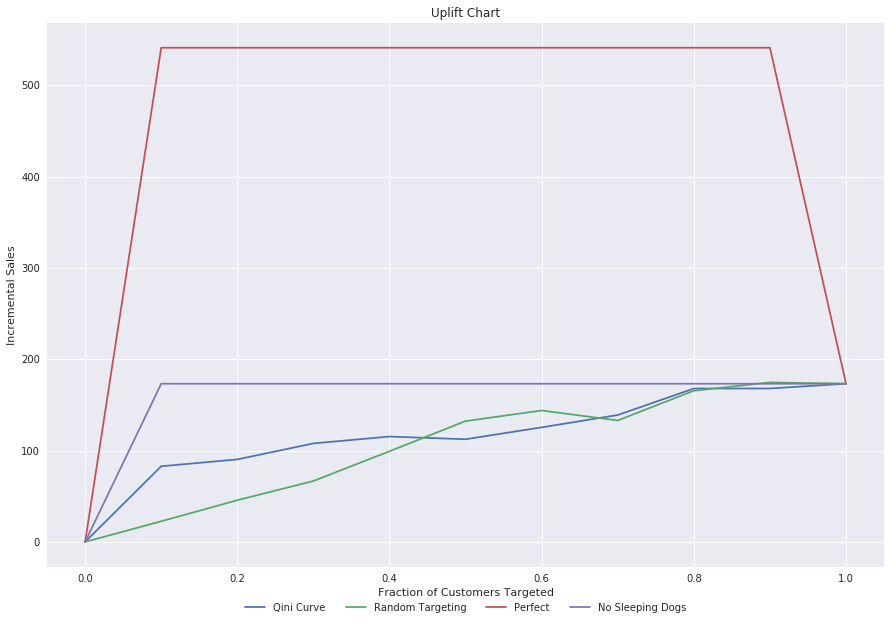

In [37]:
plt.plot(np.arange(0,1.1, .1),  uplift_ttl['q']   , label='Qini Curve')
plt.plot(np.arange(0,1.1, .1),  uplift_ttl['rq']  , label='Random Targeting')
plt.plot(np.arange(0,1.1, .1),  uplift_ttl['pq']  , label='Perfect')
plt.plot(np.arange(0,1.1, .1),  uplift_ttl['ppq'] , label='No Sleeping Dogs')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.xlabel("Fraction of Customers Targeted")
plt.ylabel("Incremental Sales")
plt.title("Uplift Chart")

How do we calculate the Qini value for the above uplift curve?

In [58]:
!cd pylift

In [59]:
ls

CSC672_EDA.ipynb  Model Evaluation Test.ipynb  pylift/
docs/             notebooks/                   Pylift Test.ipynb


In [60]:
cd pylift

/content/datalab/pylift


In [61]:
ls

docs/      LICENSE  README.md        requirements.txt  setup.py
examples/  pylift/  readthedocs.yml  rtd_reqs.txt      tests/


In [62]:
pip install .


The following command must be run outside of the IPython shell:

    $ pip install .

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [63]:
!cd pylift

In [46]:
ls

CSC672_EDA.ipynb  Model Evaluation Test.ipynb  pylift/
docs/             notebooks/                   Pylift Test.ipynb


In [65]:
!pip install .

Processing /content/datalab/pylift
  Running setup.py bdist_wheel for pylift ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-jq7zysq8/wheels/08/4d/22/3cdaec48a0215310591765d19d76359c87d7e927147864781b
Successfully built pylift


In [48]:
import pylift

In [49]:
from pylift import TransformedOutcome

In [50]:
from pylift.eval import UpliftEval

Now, I'll demonstrate my random forest model using the transformed outcome method

In [52]:
normalized_df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,0.751817,0.128434,0.240332,0.632190,0.074267,0.319622,0.445508,0.672822,0.421300,0.545341,0.553136,0.084991,1.0,0.0,0.0,1.0
1,0.699040,0.128434,0.550237,0.798120,0.000000,0.211259,0.610091,0.449747,0.358822,0.054228,1.000000,0.000000,1.0,0.0,0.0,0.0
2,0.445374,0.000000,0.888842,0.940954,0.000000,0.000000,0.695259,1.000000,0.710898,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0
3,0.914742,0.128434,0.093151,0.716626,0.000000,0.346778,0.466591,0.745898,0.632938,0.286218,1.000000,0.000000,1.0,0.0,1.0,1.0
4,0.955491,0.000000,0.740920,0.579088,0.000000,0.211259,0.456492,0.259076,0.465084,0.000000,1.000000,0.000000,1.0,0.0,0.0,1.0


In [61]:
help(TransformedOutcome)

Help on class TransformedOutcome in module pylift.methods.derivatives:

class TransformedOutcome(pylift.methods.base.BaseProxyMethod)
 |  Implement Transformed Outcome [Trees] method.
 |  
 |  Parameters
 |  ----------
 |  df : pandas.DataFrame
 |      DataFrame containing the features, test/control flag, and outcome.
 |  col_treatment : string, optional
 |      Name of the treatment column. Depends on input dataframe.
 |  col_outcome : string, optional
 |      Name of the original outcome column. Depends on input dataframe.
 |  col_transformed_outcome : string, optional
 |      Name of the new, transformed outcome. Can be whatever you want.
 |  col_policy : string or float, optional
 |      Name of the column that indicates treatment policy (probability of
 |      treatment). If a float is given, the treatment policy is assumed to be
 |      even across all rows. If not given, it is assumed that application of
 |      treatment was randomly assigned with the same probability across th

In [55]:
from sklearn.ensemble import RandomForestRegressor
help(RandomForestRegressor)

Help on class RandomForestRegressor in module sklearn.ensemble.forest:

class RandomForestRegressor(ForestRegressor)
 |  A random forest regressor.
 |  
 |  A random forest is a meta estimator that fits a number of classifying
 |  decision trees on various sub-samples of the dataset and use averaging
 |  to improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="mse")
 |      The function to measure the quality of a split. Supported criteria
 |      are "mse" for the mean squared error, which is equal to variance
 |      reduction as feature selection criterion, and "mae" for the mean
 |      absolute 

In [57]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=50)
up1 = TransformedOutcome(normalized_df, col_treatment='treatment', col_outcome='conversion', stratify=normalized_df['treatment'],
                        sklearn_model=RandomForestRegressor)

In [ ]:
up1.randomized_search(param_distributions={'max_depth': range(1,100), 'min_samples_split': range(1,1000)}, n_iter=10, n_jobs=1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] max_depth=69, min_samples_split=270 .............................
[CV]  max_depth=69, min_samples_split=270, score=0.4709667948186006, total=  59.5s
[CV] max_depth=69, min_samples_split=270 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  max_depth=69, min_samples_split=270, score=0.433553569564659, total=  55.3s
[CV] max_depth=69, min_samples_split=270 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV]  max_depth=69, min_samples_split=270, score=0.5196201244200119, total=  50.3s
[CV] max_depth=93, min_samples_split=10 ..............................
[CV]  max_depth=93, min_samples_split=10, score=0.32474211009779186, total=  48.1s
[CV] max_depth=93, min_samples_split=10 ..............................
[CV]  max_depth=93, min_samples_split=10, score=0.3109246250169682, total=  48.2s
[CV] max_depth=93, min_samples_split=10 ..............................
[CV]  max_depth=93, min_samples_split=10, score=0.38787499971773154, total= 1.0min
[CV] max_depth=38, min_samples_split=263 .............................
[CV]  max_depth=38, min_samples_split=263, score=0.4610866786156769, total=  48.0s
[CV] max_depth=38, min_samples_split=263 .............................
[CV]  max_depth=38, min_samples_split=263, score=0.43957435670642026, total=  53.5s
[CV] max_depth=38, min_samples_split=263 .............................
[CV]  max_depth=38, min_samples_split=263, score=0.49786438393023563, total=

In [68]:
up1.rand_search_.best_params_

{'max_depth': 45, 'min_samples_split': 970}

In [67]:
up1.fit(**up1.rand_search_.best_params_)

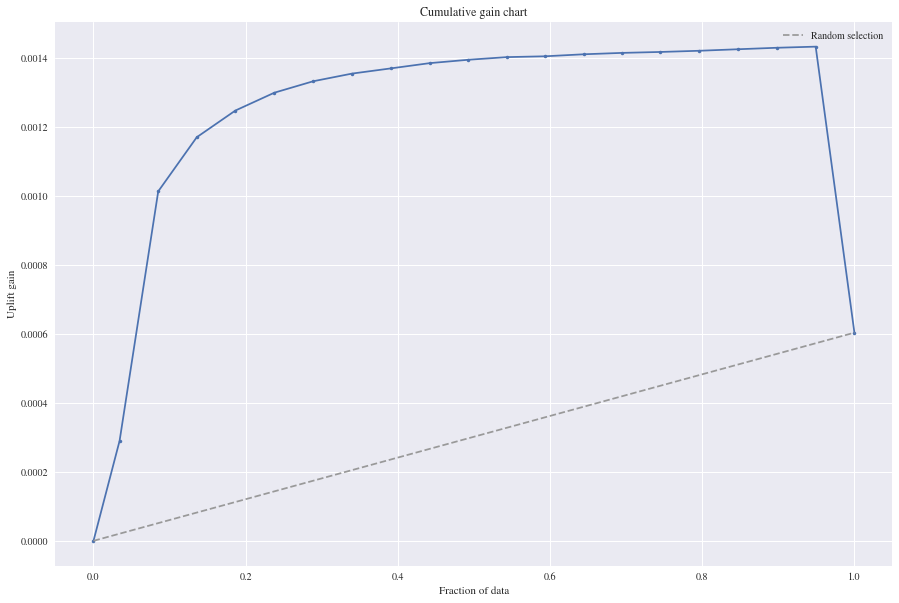

In [76]:
up1.plot()

In [71]:
up1.test_results_.q1_aqini

0.5108149819109795

In [72]:
up1.test_results_.q1_qini

0.5387970299287124

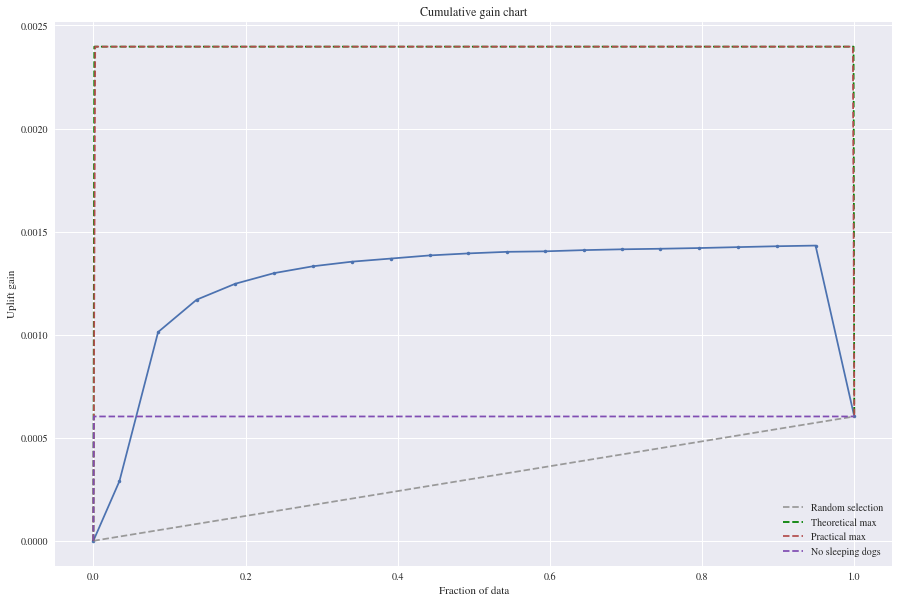

In [78]:
up1.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

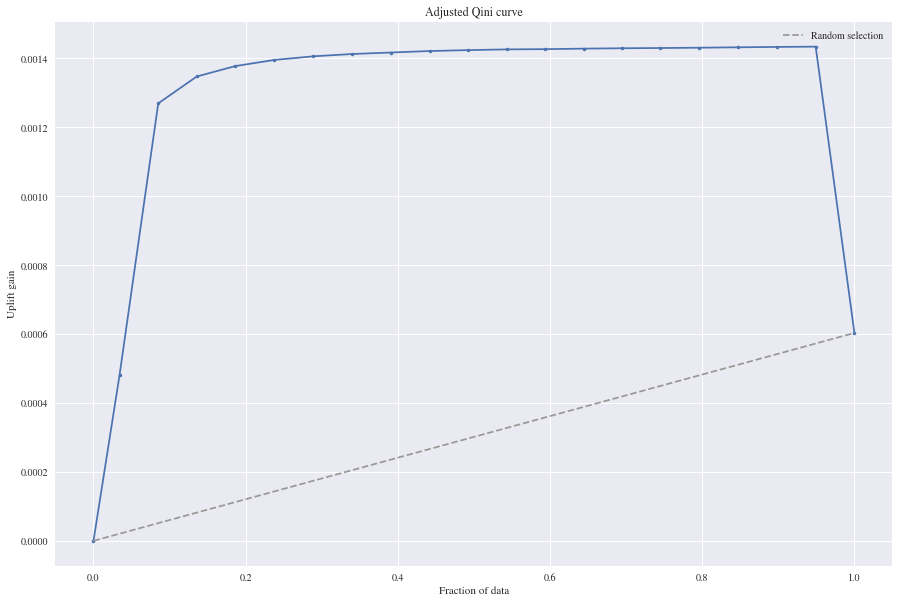

In [81]:
up1.plot_aqini()

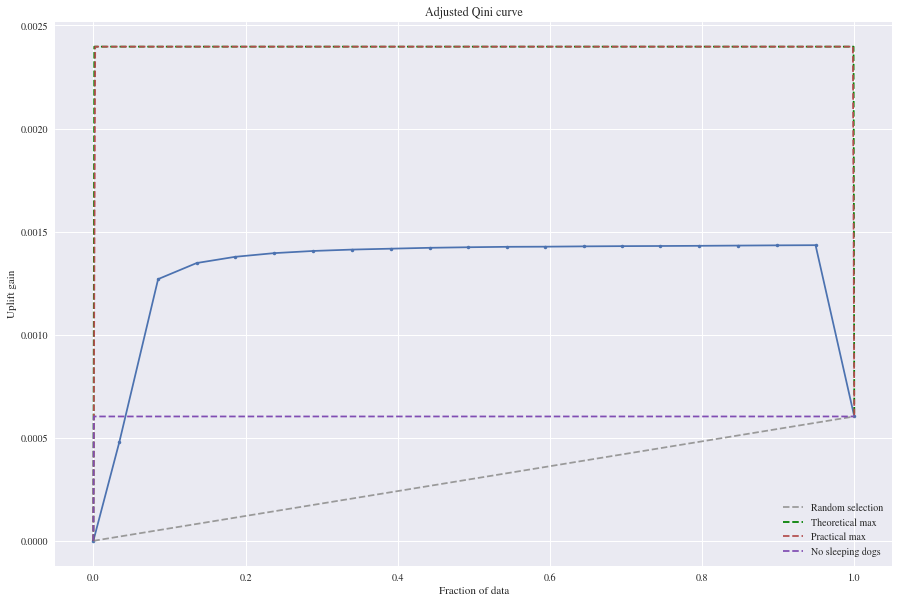

In [82]:
up1.plot_aqini(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)